Testing a full scoring process on the full set of data, each of the PCA reductions. On each set of data this entails:
- Exact scoring using a range of different neighbors using kNN trained on FULL dataset
  - Can be accomplished in a single run by using kNN to calculate distances to the max neighbor
  - Arbitrarily choosing k=4 to 14
- Average scoring using kNN trained on full dataset
  - Can average output from exact scoring above

- Exact scoring using a range of different neighbors using kNN trained on a sample of the dataset
  - Sample size 10k
  - Averaging exact score over 10 runs
  - Same number of neighbors, k=4 to 14, this is probably probematic since the distances will be inherently larger...
- Average scoring using kNN trained on sample of dataset
  - can average exact scores from above

This will result in 22 scores for every object. 10 based on exact distance to the exact k-th neighbor, 10 based on average exact distance to the k-th nearest sample point, 1 average of exact distances to exact k-th neighbors, and 1 average of average exact distances to k-th nearest sample point.

# Initializing and Importing

In [157]:
# Some standard imports for math and data handling
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
pd.set_option('display.max_columns',100)
from scipy import stats
import matplotlib.pyplot as plt
import pickle

# Imports for processing specific to this workbook
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from datetime import datetime

# Import the custom code developed for this work
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo
import quarterTools as qt
%matplotlib inline

## Importing Data

In [158]:
path_to_output = '/Users/Dan/Documents/KeplerLCs/output/'
#path_to_output = '/home/dgiles/Documents/KeplerLCs/output/'

In [3]:
Q_dict = dict()
for i in range(1,18):
    with open(path_to_output+'Q{}.coo'.format(i),'rb') as file:
        Q_dict['Q{}'.format(i)]=pickle.load(file)

In [159]:
# A lot of scores are produced for Q1 alone to alter scoring parameters. 
# These scores are saved in a seperate dataframe. 
# This call loads those scores.
# The call below saves any added scores.
with open(path_to_output+'Q1_extra_scores','rb') as f:
    Q1_scores = pickle.load(f)

In [ ]:
""" Commented out to avoid accidental overwrite"""
# To save new scores to Q1_extra_scores
#with open('/home/dgiles/Documents/KeplerLCs/output/Q1_extra_scores','wb') as f:
#    pickle.dump(Q1_scores,f)

# Scoring

## Distance based

This is essentially the most naive scoring metric given how clusters/outliers are defined. The metric is simply the distance to the k-th neighbor, min-max normalized from 0 to 1.

In [26]:
def dist_scores(data,d2s=None,kmin=4,kmax=14):
    """
    This method scores data based on distance to the k-th neighbor for a range of k's from kmin to kmax
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data, scaled appropriately.
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (if None, scores the full dataset)
        kmin (integer) - minimum neighbor to calculate the distance 
        kmax (integer) - maximum neighbor to calculate the distance 
        Note: The original DBSCAN paper suggests choosing k=4 and that k beyond this doesn't provide additional insight.
            Given the increase of d.ata volume I'm not sure this argument holds up, but the heuristic
            continues to enjoy widespread use, we use it as a base.
    Returns:
        scoress (Numpy array) - MinMax scaled scores for data in d2s. 
    """
    if type(d2s)==type(None):
        d2s=data
    nbrs = NearestNeighbors(n_neighbors=kmax+1, algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(d2s)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(distances))) 
    
    # There's probably a better way to do this with numpy arrays, but it's not worth figuring out
    for k in range(kmin,kmax):    
        k_scores = distances[:,k]
        # not using sklearn's preprocessing module bc scaling 1D at a time.
        k_scores = (k_scores-k_scores.min())/(k_scores.max()-k_scores.min()) #min max scaled
        
        scores[k-kmin]=k_scores
    k_av_scores = np.sum(distances[:,kmin:kmax],axis=1)
    k_av_scores = (k_av_scores-k_av_scores.min())/(k_av_scores.max()-k_av_scores.min()) #min max scaled
    scores[-1]=k_av_scores
    
    # TODO: readjust scaling so that the extreme outliers don't affect scores of the rest.
    # Potentially scale 90th percentile, define all beyond that as having a score of 1.
    
    return scores

#### Scaling the Q1 data

In [79]:
Q1_data_scaled = qt.data_scaler(Q_dict['Q1'].data)

/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


#### Generating exact scores for k=4 to 14

In [93]:
starttime = datetime.now()
Q1_exact_scores = dist_scores(Q1_data_scaled,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:12:35.767418


#### Putting scores into a dataframe

In [99]:
columns = ['{}'.format(i) for i in range(4,14)]
columns.append('Average')
# First instance of Q1_scores, defines the dataframe. All others will add to this.
Q1_scores = pd.DataFrame(data=Q1_exact_scores.T,columns=columns,index=Q1_data_scaled.index)

The following method calls the previous method, but generates a sample to calculate distances against

In [15]:
def dist_scores_s(data,d2s=None,samp_size=10000,n_iter=10,kmin=4,kmax=14):
    """
    The 's' stands for speed
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data (scaled and culled of irrelevant data)
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored (optional if interested in a subset)
        k (integer) - Neighbor to which the distance is considered the score
        n_iter (integer) - Number of iterations, 
            ***TODO: if None, will loop until scores converge (not implemented)***
    Returns:
        scores (Numpy array) - MinMax scaled scores for data in d2s. 
        
    Purpose:
        Calculate scores for each point within the dataset in an efficient manner. The score is based on the 
        distance to the k nearest neighbor, but in this implementation a reference sample is generated and
        used to calculate distances instead of the genuine neighbors. This is in order to make this process 
        scalable to larger datasets, calculating the actual k nearest neighbor distance for all points for
        high dimensional data is not particularly efficient.
        Consideration: use an average of k nearest neighbor distances for several values of k to account for 
        imperfect distance analogies.
        
    """
    if type(d2s)==type(None):
        d2s=data
    
    # Initial run
    ref_data_sample = data.sample(n=samp_size)
    scores_i = dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    for i in range(n_iter):
        # Creating a random sample of reference points to which distances will be calculated for all data
        # Speed improvements: using ball_tree to calculate distance to only k+1 neighbors
        # Using subset of reference points for calculating distances
        ref_data_sample = data.sample(n=samp_size)
        scores_i += dist_scores(ref_data_sample,d2s=d2s,kmin=kmin,kmax=kmax)
    
    # empty numpy array which will contain scores, one additional column for average score
    scores = np.zeros((kmax-kmin+1,len(data))) 
    scores = scores_i/(n_iter+1)
    return scores
    

#### Generating exact scores to sample subsets

In [147]:
starttime = datetime.now()
Q1_sample_scores = dist_scores_s(Q1_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
print("Time to calculate scores: {}".format(datetime.now()-starttime))

Time to calculate scores: 0:09:39.474256


#### Saving as a dataframe

In [148]:
columns=['s{}'.format(i) for i in range(4,14)]
columns.append('sAverage')
scoresdf_s = pd.DataFrame(data=Q1_sample_scores.T,columns=columns,index=Q1_data_scaled.index)

#### Adding to the main dataframe

In [154]:
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

#### Generating scores for PCA reductions, both full and sampled

In [247]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_Average'.format(red_key))
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_sAverage'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]

    for col in scoresdf.columns:
        Q1_scores[col]=scoresdf[col]

Scoring Q1
Time to score exact neighbors: 0:09:36.105189
Total time to score: 0:19:17.315595
Scoring Q1
Time to score exact neighbors: 0:10:11.967827
Total time to score: 0:19:44.838978
Scoring Q1
Time to score exact neighbors: 0:14:53.848768
Total time to score: 0:25:02.276622


#### Scoring against a 1000 sample subset (50 and 10 subsets for s2 and s3 respectively)

In [341]:
Q_key = 'Q1'
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
columns=['s2_{}'.format(i) for i in range(4,14)]
columns.append('s2Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
columns=['s3_{}'.format(i) for i in range(4,14)]
columns.append('s3Average')
scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:04:52.847826
Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:01:07.078921


#### Scoring against subsets for PCA reductions 

In [325]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=50,kmin=4,kmax=14)
    columns=['{}_s2{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s2Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q1_scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:05:18.053207
Scoring Q1
Total time to score: 0:05:34.553075
Scoring Q1
Total time to score: 0:05:46.419034


In [330]:
Q_key = 'Q1'
for red_key in Q_dict[Q_key].reductions.keys():
    print("Scoring {}".format(Q_key))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=14)
    columns=['{}_s3{}'.format(red_key,i) for i in range(4,14)]
    columns.append('{}_s3Average'.format(red_key))
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
    print("Total time to score: {}".format(datetime.now()-starttime))
    for col in scoresdf_s.columns:
        Q1_scores[col]=scoresdf_s[col]

Scoring Q1
Total time to score: 0:01:05.655675
Scoring Q1
Total time to score: 0:00:57.573196
Scoring Q1
Total time to score: 0:01:09.893811


#### Expanding scores to k=4 to 103 

In [355]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=1000,n_iter=10,kmin=4,kmax=104)

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


In [376]:
scoresdf_s = pd.DataFrame({'av_s4_14': np.mean(Q_sample_scores.T[:,0:10],axis=1),
                           'av_s14_24': np.mean(Q_sample_scores.T[:,10:20],axis=1),
                           'av_s24_34': np.mean(Q_sample_scores.T[:,20:30],axis=1),
                           'av_s34_44': np.mean(Q_sample_scores.T[:,30:40],axis=1),
                           'av_s44_54': np.mean(Q_sample_scores.T[:,40:50],axis=1),
                           'av_s54_64': np.mean(Q_sample_scores.T[:,50:60],axis=1),
                           'av_s64_74': np.mean(Q_sample_scores.T[:,60:70],axis=1),
                           'av_s74_84': np.mean(Q_sample_scores.T[:,70:80],axis=1),
                           'av_s84_94': np.mean(Q_sample_scores.T[:,80:90],axis=1),
                           'av_s94_10': np.mean(Q_sample_scores.T[:,90:100],axis=1),
                           'av_s4_104': np.mean(Q_sample_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)

#print("Total time to score: {}".format(datetime.now()-starttime))
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

In [ ]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_4_14': np.mean(Q_exact_scores.T[:,0:10],axis=1),
                           'av_14_24': np.mean(Q_exact_scores.T[:,10:20],axis=1),
                           'av_24_34': np.mean(Q_exact_scores.T[:,20:30],axis=1),
                           'av_34_44': np.mean(Q_exact_scores.T[:,30:40],axis=1),
                           'av_44_54': np.mean(Q_exact_scores.T[:,40:50],axis=1),
                           'av_54_64': np.mean(Q_exact_scores.T[:,50:60],axis=1),
                           'av_64_74': np.mean(Q_exact_scores.T[:,60:70],axis=1),
                           'av_74_84': np.mean(Q_exact_scores.T[:,70:80],axis=1),
                           'av_84_94': np.mean(Q_exact_scores.T[:,80:90],axis=1),
                           'av_94_104': np.mean(Q_exact_scores.T[:,90:100],axis=1),
                           'av_4_104': np.mean(Q_exact_scores.T[:,0:100],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

#### Expanding scores out to k=1003

In [391]:
print("Scoring {}".format(Q_key))
starttime = datetime.now()
Q_data_scaled = qt.data_scaler(Q_dict[Q_key].data)
Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=1004)
print("Total time to score: {}".format(datetime.now()-starttime))
scoresdf_s = pd.DataFrame({'av_104_204': np.mean(Q_exact_scores.T[:,100:200],axis=1),
                           'av_204_304': np.mean(Q_exact_scores.T[:,200:300],axis=1),
                           'av_304_404': np.mean(Q_exact_scores.T[:,300:400],axis=1),
                           'av_404_504': np.mean(Q_exact_scores.T[:,400:500],axis=1),
                           'av_504_604': np.mean(Q_exact_scores.T[:,500:600],axis=1),
                           'av_604_704': np.mean(Q_exact_scores.T[:,600:700],axis=1),
                           'av_704_804': np.mean(Q_exact_scores.T[:,700:800],axis=1),
                           'av_804_904': np.mean(Q_exact_scores.T[:,800:900],axis=1),
                           'av_904_1004': np.mean(Q_exact_scores.T[:,900:1000],axis=1),
                           'av_4_1004': np.mean(Q_exact_scores.T[:,0:1000],axis=1)},index=Q_data_scaled.index)
for col in scoresdf_s.columns:
    Q1_scores[col]=scoresdf_s[col]

Scoring Q1


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


Total time to score: 0:15:42.595476


In [278]:
Q1_scores['Average']=np.mean(Q1_scores.iloc[:,0:10],axis=1)
Q1_scores['sAverage']=np.mean(Q1_scores.iloc[:,11:21],axis=1)
Q1_scores['PCA90_Average']=np.mean(Q1_scores.iloc[:,22:32],axis=1)
Q1_scores['PCA90_sAverage']=np.mean(Q1_scores.iloc[:,32:42],axis=1)
Q1_scores['PCA95_Average']=np.mean(Q1_scores.iloc[:,42:52],axis=1)
Q1_scores['PCA95_sAverage']=np.mean(Q1_scores.iloc[:,52:62],axis=1)
Q1_scores['PCA99_Average']=np.mean(Q1_scores.iloc[:,62:72],axis=1)
Q1_scores['PCA99_sAverage']=np.mean(Q1_scores.iloc[:,72:82],axis=1)

## Exact-k (low values of k) versus Average

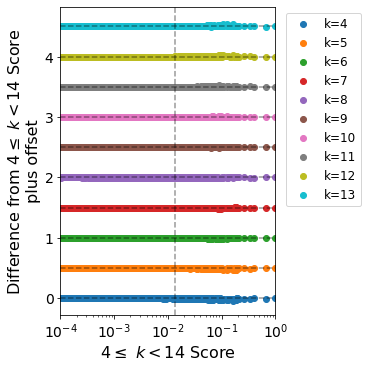

In [165]:
ref='Average'
labels = ["k={}".format(i) for i in range(4,14)]
cols = ["{}".format(i) for i in range(4,14)]
offset = 0.5
fig,ax = plt.subplots(1,1,figsize=(5,5),constrained_layout=True)
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)

def plot_axis(data,cols,labels,ref,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label="{}".format(labels[i],i*offset))
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from $4\leq~k<14$ Score\nplus offset",fontsize=16)
    axis.set_xlabel("$4\leq~k<14$ Score",fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)

plot_axis(scores_sorted,cols,labels,ref,offset,ax)
plt.savefig('Plots/PlotsForScoringPaper/ExactVsAverage.png')


Text(0.5, 0, 'Rank Range')

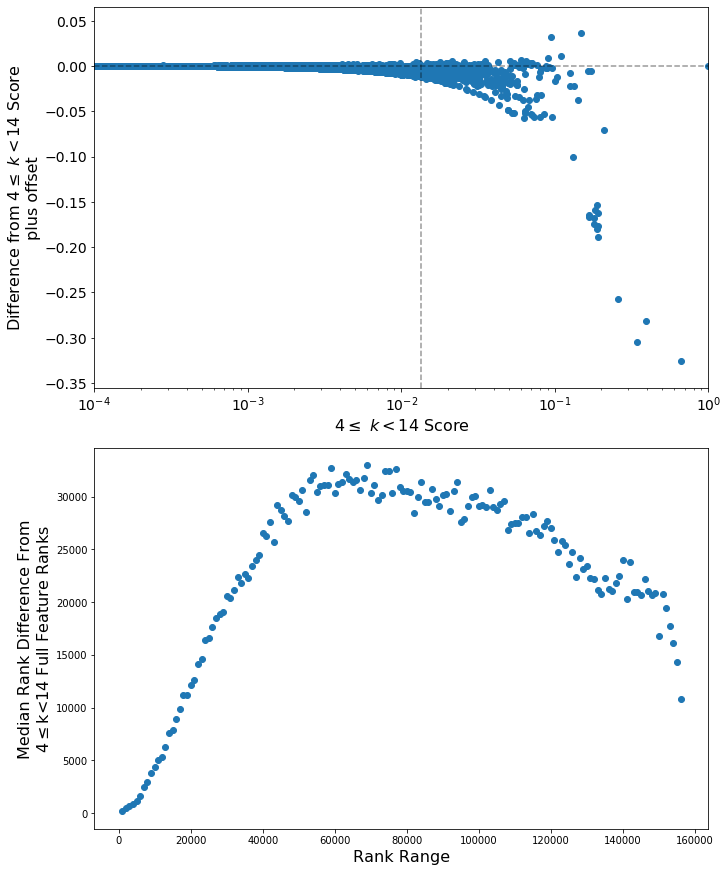

In [211]:
ref='Average'
labels = ["Feature Subset"]
cols = ["ft_sub"]
offset = 0.5
fig,ax = plt.subplots(2,1,figsize=(10,12),constrained_layout=True)
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)

def plot_axis(data,cols,labels,ref,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label="{}".format(labels[i],i*offset))
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from $4\leq~k<14$ Score\nplus offset",fontsize=16)
    axis.set_xlabel("$4\leq~k<14$ Score",fontsize=16)
    axis.set_xlim(1E-4,1E0)
plot_axis(scores_sorted,cols,labels,ref,offset,ax[0])
ax[1].scatter(range(1000,157000,1000),
            median_rank_diffs['ft_sub'],
            label="Feature Subset $4\leq k<14$")
ax[1].set_ylabel("Median Rank Difference From\n4$\leq$k<14 Full Feature Ranks",fontsize=16)
ax[1].set_xlabel("Rank Range",fontsize=16)

In [176]:
ref='Average'
ranks_sorted = Q1_scores.rank(ascending=False).sort_values(by=ref)
rank_diff = pd.DataFrame(index=ranks_sorted.index,
                        data={col:ranks_sorted.loc[:,col]-ranks_sorted.loc[:,ref] for col in ['ft_sub']})

median_rank_diffs = pd.DataFrame(index=["{} to {}".format(i*1000,(i+1)*1000) for i in range(100)],
                                columns=['ft_sub'])
for i in range(156):
    median_rank_diffs.loc["{} to {}".format(i*1000,(i+1)*1000),:] = rank_diff.iloc[i*1000:(i+1)*1000,:].abs().median()
    

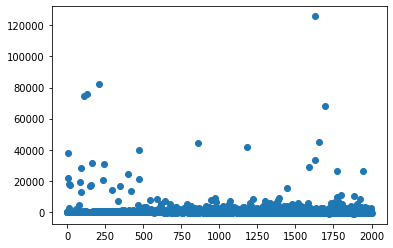

In [186]:
plt.scatter(ranks_sorted.head(2000).Average,rank_diff.head(2000).ft_sub)

In [175]:
scores_sorted=Q1_scores.sort_values(by='ft_sub',ascending=False)
top_outs = scores_sorted.head(10).index


#### Exact vs. Average Doesn't have a huge impact for most points.

## High values of k 

/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


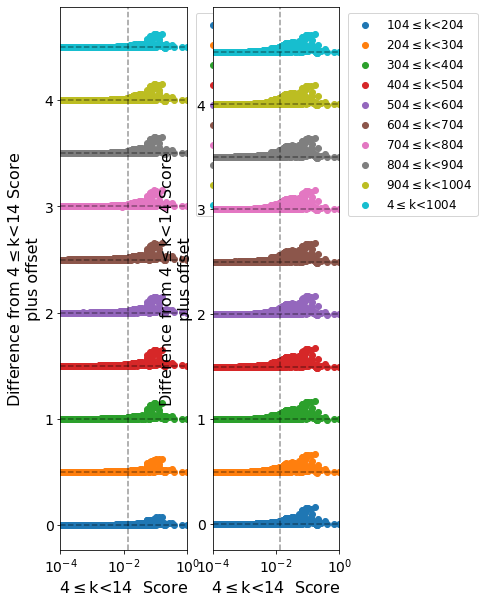

In [217]:
ref='Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
offset = 0.5
fig,ax = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)

def plot_axis(data,cols,ref,labels,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label=labels[i])
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from 4$\leq$k<14 Score\nplus offset",fontsize=16)
    axis.set_xlabel('4$\leq$k<14  Score'.format(ref),fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)
cols = ['av_{}_{}'.format(i,i+10) for i in range(14,104,10)]
labels = ["{}$\leq$k<{}".format(i,i+10) for i in range(14,104,10)]
cols.append('av_4_104')
labels.append("4$\leq$k<104")
plot_axis(scores_sorted,cols,ref,labels,offset,ax[0]) 
cols = ['av_{}_{}'.format(i,i+100) for i in range(104,1004,100)]
cols.append('av_4_1004')
labels = ["{}$\leq$k<{}".format(i,i+100) for i in range(104,1004,100)]
labels.append("4$\leq$k<1004")
plot_axis(scores_sorted,cols,ref,labels,offset,ax[1])
#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
plt.savefig('Plots/PlotsForScoringPaper/HighK.png')
#plt.tight_layout()

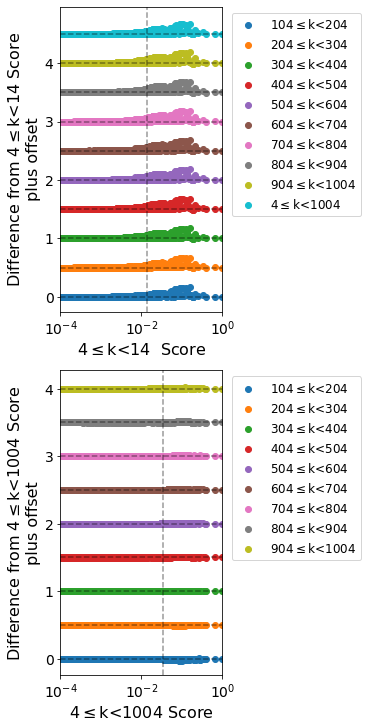

In [219]:
ref='Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
offset = 0.5
fig,ax = plt.subplots(2,1,figsize=(5,10),constrained_layout=True)

def plot_axis(data,cols,ref,labels,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label=labels[i])
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from 4$\leq$k<14 Score\nplus offset",fontsize=16)
    axis.set_xlabel('4$\leq$k<14  Score'.format(ref),fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)
cols = ['av_{}_{}'.format(i,i+100) for i in range(104,1004,100)]
cols.append('av_4_1004')
labels = ["{}$\leq$k<{}".format(i,i+100) for i in range(104,1004,100)]
labels.append("4$\leq$k<1004")
plot_axis(scores_sorted,cols,ref,labels,offset,ax[0])
#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
#plt.savefig('Plots/PlotsForScoringPaper/HighK.png')
#plt.tight_layout()
ref="av_4_1004"
cols = ['av_{}_{}'.format(i,i+100) for i in range(104,1004,100)]
labels = ["{}$\leq$k<{}".format(i,i+100) for i in range(104,1004,100)]
plot_axis(scores_sorted,cols,ref,labels,offset,ax[1])
ax[1].set_xlabel("4$\leq$k<1004 Score")
ax[1].set_ylabel("Difference from 4$\leq$k<1004 Score\nplus offset",fontsize=16)
#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
plt.savefig('Plots/PlotsForScoringPaper/HighKInvariance.png')
#plt.tight_layout()

### Larger choices of k impact scores a bit compared to small choices of k, but aren't very different form one another

## Sampling

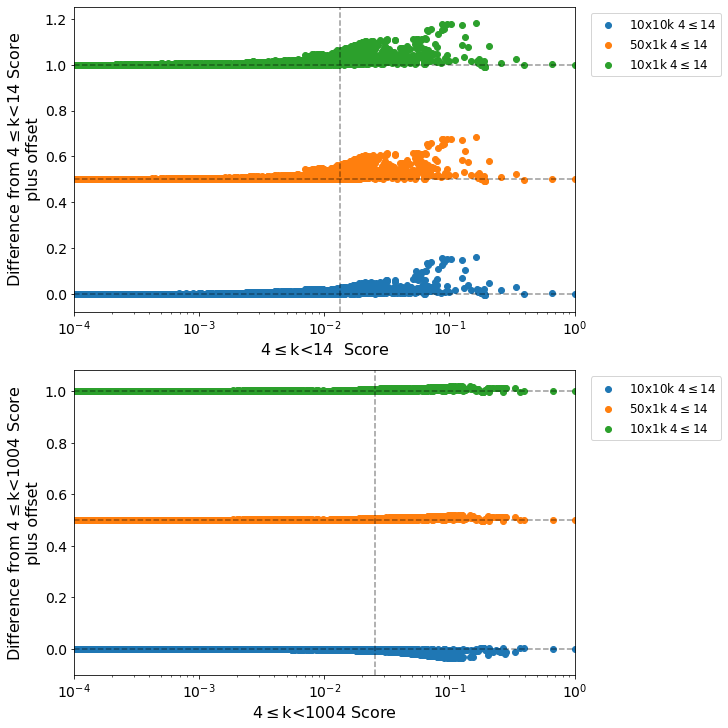

In [195]:
ref='Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
offset = 0.5
fig,ax = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)

def plot_axis(data,cols,ref,labels,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label=labels[i])
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from 4$\leq$k<14 Score\nplus offset",fontsize=16)
    axis.set_xlabel('4$\leq$k<14  Score'.format(ref),fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)
cols = ['sAverage','s2Average','s3Average']
labels = ['10x10k 4$\leq$14','50x1k 4$\leq$14','10x1k 4$\leq$14']
plot_axis(scores_sorted,cols,ref,labels,offset,ax[0]) 
ref='av_4_1004'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
plot_axis(scores_sorted,cols,ref,labels,offset,ax[1])
ax[1].set_xlabel("4$\leq$k<1004 Score")
ax[1].set_ylabel("Difference from 4$\leq$k<1004 Score\nplus offset",fontsize=16)
#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
plt.savefig('Plots/PlotsForScoringPaper/Sample_Params.png')
#plt.tight_layout()

### Sampling impacts scores, as compared to small k, but strongly resemble large k. Sampling choices have minimal impact.

## PCA Reductions

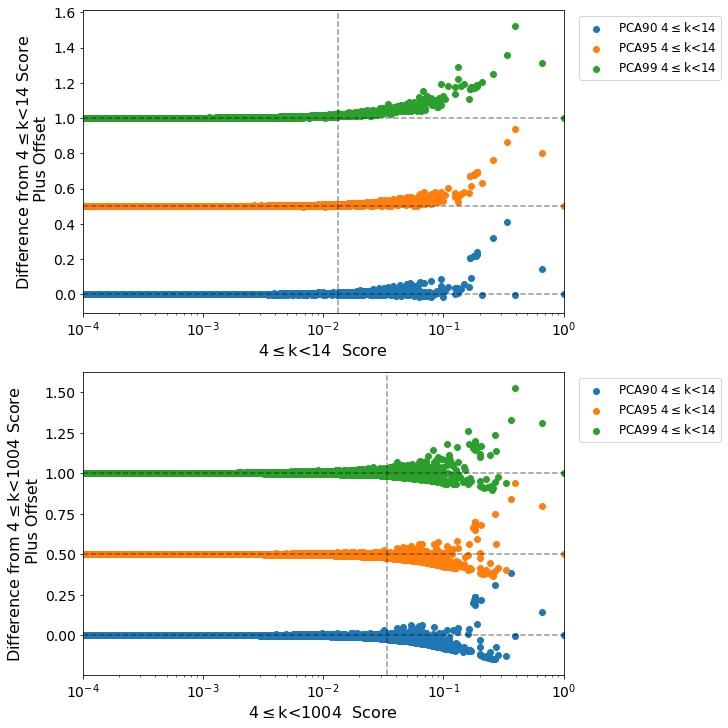

In [203]:
ref='Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
offset = 0.5
fig,ax = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)

def plot_axis(data,cols,ref,labels,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label=labels[i])
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from 4$\leq$k<14 Score\n Plus Offset",fontsize=16)
    axis.set_xlabel('4$\leq$k<14  Score'.format(ref),fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)
    
cols = ['PCA90_Average','PCA95_Average','PCA99_Average']
labels = ['PCA90 4$\leq$k<14','PCA95 4$\leq$k<14','PCA99 4$\leq$k<14']
plot_axis(scores_sorted,cols,ref,labels,offset,ax[0]) 
ref = 'av_4_1004'
plot_axis(scores_sorted,cols,ref,labels,offset,ax[1])
ax[1].set_ylabel("Difference from 4$\leq$k<1004 Score\n Plus Offset",fontsize=16)
ax[1].set_xlabel('4$\leq$k<1004  Score'.format(ref),fontsize=16)
#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
plt.savefig('Plots/PlotsForScoringPaper/PCA_Averages.png')
#plt.tight_layout()

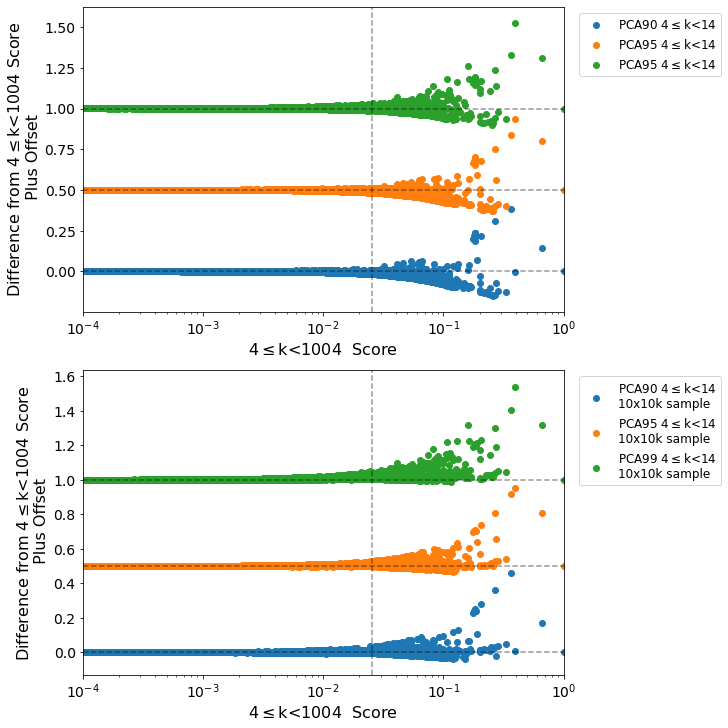

In [191]:
ref='av_4_1004'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
offset = 0.5
fig,ax = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)

def plot_axis(data,cols,ref,labels,offset,axis):
    for i,col in enumerate(cols):
        axis.scatter(data.loc[:,ref],data.loc[:,col]-data.loc[:,ref]+i*offset,label=labels[i])
        axis.axhline(i*offset,linestyle='--',c='black',alpha=.4)
    axis.axvline(data.loc[:,ref].head(1000)[-1],linestyle='--',c='black',alpha=.4)
    axis.set_xscale('log')
    axis.tick_params(labelsize=14)
    axis.set_ylabel("Difference from 4$\leq$k<1004 Score\n Plus Offset",fontsize=16)
    axis.set_xlabel('4$\leq$k<1004  Score'.format(ref),fontsize=16)
    axis.legend(loc=2,bbox_to_anchor=(1.02,1),ncol=1, fontsize=12)
    axis.set_xlim(1E-4,1E0)
    
cols = ['PCA90_Average','PCA95_Average','PCA99_Average']
labels = ['PCA90 4$\leq$k<14','PCA95 4$\leq$k<14','PCA95 4$\leq$k<14']
plot_axis(scores_sorted,cols,ref,labels,offset,ax[0]) 
ref = 'av_4_1004'
cols = ['PCA90_sAverage','PCA95_sAverage','PCA99_sAverage']
labels = ['PCA90 4$\leq$k<14\n10x10k sample',
          'PCA95 4$\leq$k<14\n10x10k sample',
          'PCA99 4$\leq$k<14\n10x10k sample']
plot_axis(scores_sorted,cols,ref,labels,offset,ax[1])

#ax[0].set_title("Scored Against Full Dataset",fontsize=16)
#ax[1].set_title("Scored Against Subset",fontsize=16)
#plt.savefig('Plots/PlotsForScoringPaper/PCA_Averages.png')
#plt.tight_layout()

### PCA has a much larger effect on scoring, and is not consistent with sampling or high-k scores.

## Checking rank differences due to PCA reduction

In [197]:
ref='Average'
ranks_sorted = Q1_scores.rank(ascending=False).sort_values(by=ref)
rank_diff = pd.DataFrame(index=ranks_sorted.index,
                        data={col:ranks_sorted.loc[:,col]-ranks_sorted.loc[:,ref] for col in ['ft_sub','PCA90_Average','PCA95_Average','PCA99_Average']})


In [198]:
median_rank_diffs = pd.DataFrame(index=["{} to {}".format(i*1000,(i+1)*1000) for i in range(100)],
                                columns=['ft_sub','PCA90_Average','PCA95_Average','PCA99_Average'])
for i in range(156):
    median_rank_diffs.loc["{} to {}".format(i*1000,(i+1)*1000),:] = rank_diff.iloc[i*1000:(i+1)*1000,:].abs().median()
    

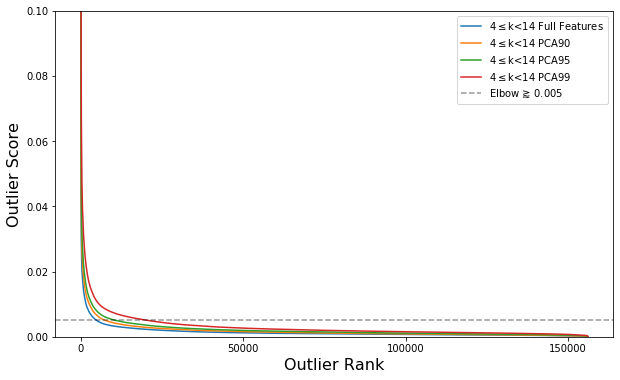

In [201]:
scores_sorted = Q1_scores.sort_values(by='Average',ascending=False)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(len(scores_sorted)),scores_sorted.Average,label="4$\leq$k<14 Full Features")
ref = 'PCA90_Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
ax.plot(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA90")
ref = 'PCA95_Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
ax.plot(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA95")
ref = 'PCA99_Average'
scores_sorted = Q1_scores.sort_values(by=ref,ascending=False)
ax.plot(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA99")

plt.axhline(.005,linestyle='--',color='black',alpha=.4,label='Elbow $\gtrapprox$ 0.005')
plt.ylabel('Outlier Score',fontsize=16)
plt.xlabel('Outlier Rank',fontsize=16)
plt.ylim(0,.1)
plt.xticks([0,50000,100000,150000])
#plt.yscale('log')
#plt.ylim(10E-6,10E0)
plt.legend()

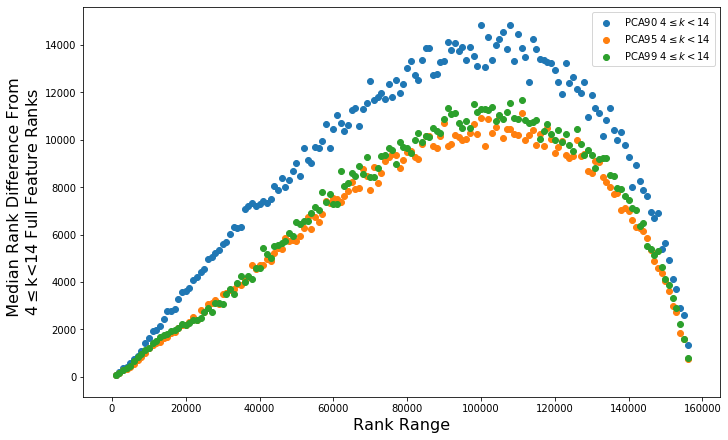

In [202]:
#median_rank_diffs.plot()
fig,ax = plt.subplots(1,1,figsize=(10,6),constrained_layout=True)

ax.scatter(range(1000,157000,1000),
            median_rank_diffs['PCA90_Average'],
            label="PCA90 $4\leq k<14$")
ax.scatter(range(1000,157000,1000),
            median_rank_diffs['PCA95_Average'],
            label="PCA95 $4\leq k<14$")
ax.scatter(range(1000,157000,1000),
            median_rank_diffs['PCA99_Average'],
            label="PCA99 $4\leq k<14$")
ax.set_ylabel("  Median Rank Difference From\n4$\leq$k<14 Full Feature Ranks",fontsize=16)
ax.set_xlabel("Rank Range",fontsize=16)
ax.legend()

### Ranks vary a good amount on average for most points, but we only really care about the most outlying points which evidently vary nominally. 

## Score Scaling

In [160]:
with open('scores/Average','rb') as f:
    Average_scores = pickle.load(f)
    Average_scores.set_index('KIC',inplace=True)

In [219]:
Average_scores.describe()

,KIC,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
count,2.012660e+05,156126.000000,166279.000000,165531.000000,169817.000000,166268.000000,165283.000000,163305.000000,167783.000000,167243.000000,166897.000000,164065.000000,166867.000000,166631.000000,166910.000000,164737.000000,167508.000000,167575.000000
mean,8.545279e+06,0.001478,0.001238,0.000835,0.000712,0.000957,0.000498,0.000484,0.000655,0.000734,0.001008,0.000582,0.000880,0.001166,0.001226,0.000918,0.000784,0.000619
std,8.373807e+06,0.004587,0.004973,0.003609,0.003787,0.003745,0.003134,0.002976,0.003146,0.003950,0.004582,0.003298,0.004428,0.005085,0.005554,0.004784,0.003805,0.002799
min,7.570760e+05,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.732821e+06,0.000599,0.000429,0.000279,0.000227,0.000295,0.000177,0.000164,0.000234,0.000231,0.000348,0.000205,0.000297,0.000380,0.000409,0.000305,0.000267,0.000295
50%,8.110344e+06,0.000881,0.000663,0.000433,0.000361,0.000465,0.000271,0.000257,0.000352,0.000362,0.000527,0.000310,0.000457,0.000578,0.000637,0.000472,0.000403,0.000419
75%,1.002978e+07,0.001456,0.001151,0.000773,0.000662,0.000883,0.000485,0.000481,0.000613,0.000693,0.000927,0.000562,0.000806,0.001062,0.001128,0.000852,0.000721,0.000648
max,1.000043e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'Score')

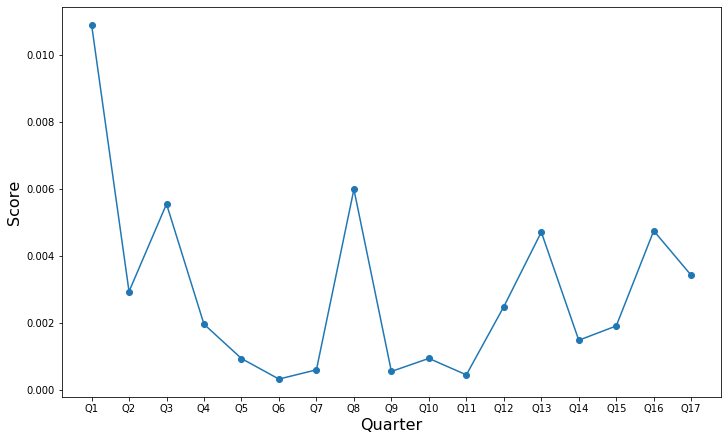

In [244]:
fig,ax = plt.subplots(1,1,figsize=(10,6),constrained_layout=True)
ax.set_xlabel('Quarter',fontsize=16)
ax.set_ylabel('Score',fontsize=16)

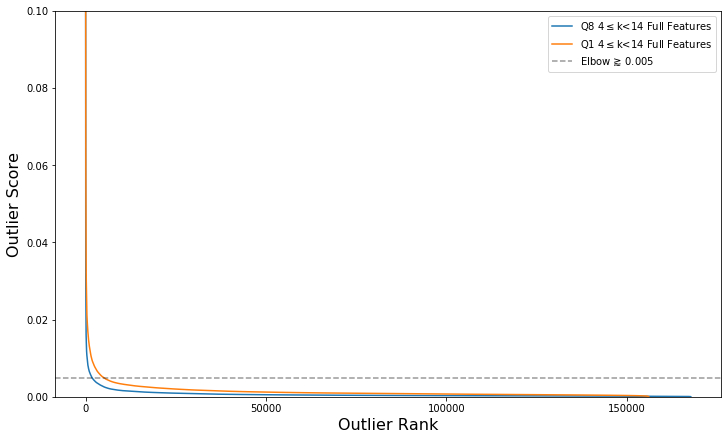

In [246]:
scores_sorted = Average_scores.Q8.sort_values(ascending=False)
fig,ax= plt.subplots(1,1,figsize=(10,6),constrained_layout=True)
ax.plot(range(len(scores_sorted)),scores_sorted,label="Q8 4$\leq$k<14 Full Features")
scores_sorted = Average_scores.Q1.sort_values(ascending=False)
ax.plot(range(len(scores_sorted)),scores_sorted,label="Q1 4$\leq$k<14 Full Features")
plt.axhline(.005,linestyle='--',color='black',alpha=.4,label='Elbow $\gtrapprox$ 0.005')
plt.ylabel('Outlier Score',fontsize=16)
plt.xlabel('Outlier Rank',fontsize=16)
plt.ylim(0,.1)
plt.xticks([0,50000,100000,150000])
#plt.yscale('log')
#plt.ylim(10E-6,10E0)
plt.legend()

### Elbows are in different places for different quarters

In [161]:
with open('scores/Unreducedref','rb') as f:
    Scaled_scores = pickle.load(f)
    Scaled_scores.set_index('KIC',inplace=True)

In [235]:
Scaled_scores.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
count,156126.000000,166279.000000,165531.000000,169817.000000,166268.000000,165283.000000,163305.000000,167783.000000,167243.000000,166897.000000,164065.000000,166867.000000,166631.000000,166910.000000,164737.000000,167508.000000,167575.000000
mean,0.020841,0.025841,0.023387,0.028435,0.021869,0.071993,0.062184,0.034849,0.027383,0.028802,0.043555,0.025167,0.024581,0.027169,0.028905,0.034823,0.063690
std,0.056615,0.082208,0.076008,0.103866,0.069408,0.291267,0.244547,0.117245,0.099298,0.098271,0.167595,0.087801,0.083744,0.091643,0.105381,0.123973,0.205624
min,0.003112,0.003279,0.002832,0.003022,0.002101,0.008471,0.007795,0.005046,0.003206,0.003158,0.005126,0.003413,0.002827,0.003162,0.003007,0.004105,0.010450
25%,0.008964,0.009582,0.008705,0.010109,0.007671,0.027325,0.023242,0.013667,0.009709,0.010165,0.015564,0.009708,0.008363,0.009782,0.010380,0.012589,0.030459
50%,0.012392,0.013880,0.012456,0.014615,0.010898,0.039300,0.033138,0.018875,0.013818,0.014696,0.022635,0.013505,0.011975,0.014221,0.014823,0.017937,0.041546
75%,0.019417,0.022770,0.020593,0.025441,0.019265,0.067436,0.059239,0.031111,0.024852,0.025237,0.040167,0.022483,0.021349,0.023886,0.025730,0.030931,0.064035
max,9.082508,13.332826,16.411939,23.628671,13.567386,85.361138,75.102682,31.836581,21.497716,17.151070,45.184539,17.194822,12.935282,13.561670,18.640863,27.328519,66.476391


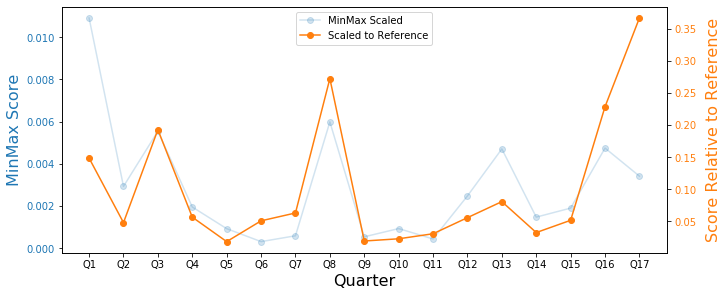

In [162]:
fig,ax = plt.subplots(1,1,figsize=(10,4),constrained_layout=True)
ax.plot(Average_scores.loc[8462852,:],marker='o',label="MinMax Scaled",alpha=0.2)
ax.plot([],[],marker='o',label="Scaled to Reference")
ax2 = ax.twinx()
ax2.plot(Scaled_scores.loc[8462852,:],color='tab:orange',marker='o',label="Scaled to Reference")
ax.set_xlabel('Quarter',fontsize=16)
ax.set_ylabel('MinMax Score',fontsize=16,color='tab:blue')
ax.tick_params(axis='y',labelcolor='tab:blue')
ax2.set_ylabel('Score Relative to Reference',fontsize=16,color='tab:orange',labelpad=10)
ax2.tick_params(axis='y',labelcolor='tab:orange')
ax.legend(loc='upper center')

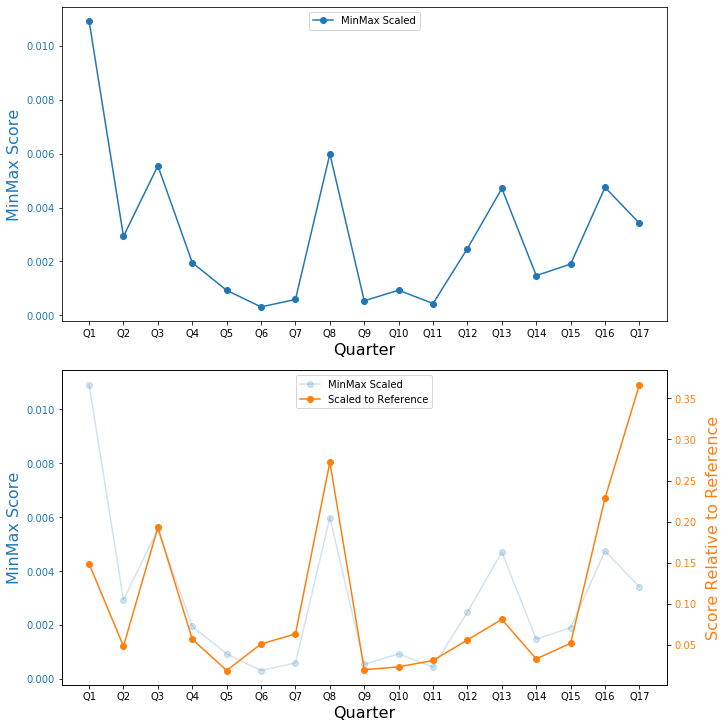

In [304]:
fig,ax = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)
fig.patch.set_facecolor('white')
ax[0].plot(Average_scores.loc[8462852,:],marker='o',label="MinMax Scaled")
ax[0].set_xlabel('Quarter',fontsize=16)
ax[0].set_ylabel('MinMax Score',fontsize=16,color='tab:blue')
ax[0].tick_params(axis='y',labelcolor='tab:blue')
ax[0].legend(loc='upper center')

ax[1].plot(Average_scores.loc[8462852,:],marker='o',label="MinMax Scaled",alpha=0.2)
ax[1].plot([],[],marker='o',label="Scaled to Reference")
ax2 = ax[1].twinx()
ax2.plot(Scaled_scores.loc[8462852,:],color='tab:orange',marker='o',label="Scaled to Reference")
ax[1].set_xlabel('Quarter',fontsize=16)
ax[1].set_ylabel('MinMax Score',fontsize=16,color='tab:blue')
ax[1].tick_params(axis='y',labelcolor='tab:blue')
ax2.set_ylabel('Score Relative to Reference',fontsize=16,color='tab:orange',labelpad=10)
ax2.tick_params(axis='y',labelcolor='tab:orange')
ax[1].legend(loc='upper center')
plt.savefig('Plots/PlotsForScoringPaper/Boyajian_scores.png')

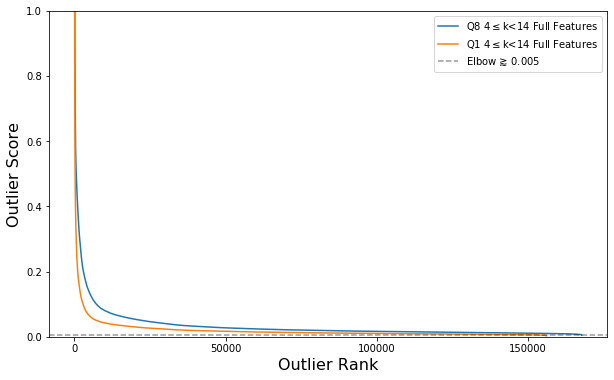

In [239]:
scores_sorted = Scaled_scores.Q8.sort_values(ascending=False)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(range(len(scores_sorted)),scores_sorted,label="Q8 4$\leq$k<14 Full Features")
scores_sorted = Scaled_scores.Q1.sort_values(ascending=False)
ax.plot(range(len(scores_sorted)),scores_sorted,label="Q1 4$\leq$k<14 Full Features")
plt.axhline(.005,linestyle='--',color='black',alpha=.4,label='Elbow $\gtrapprox$ 0.005')
plt.ylabel('Outlier Score',fontsize=16)
plt.xlabel('Outlier Rank',fontsize=16)
plt.ylim(0,1)
plt.xticks([0,50000,100000,150000])
#plt.yscale('log')
#plt.ylim(10E-6,10E0)
plt.legend()

Low neighber sampled data strongly resembles high neighbors from the full data. Sampling 1k neighbors decreases density by a factor of ~150. The distance to the 4th nearest neighbor in the sample represents the distance to ~600th nearest neighbor in the full dataset.

Increasing the sample average to include more neighbors (4th to 14th vs 4th to 104th) does not significantly impact the sampled scores.

For the full data, the average score for lower neighbors (4th to 14th, 14th to 24th) has much more variance than the average scores for higher neighbors. Specifically, scoring by closer neighbors tends to result in lower scores below ~0.4 as averaged over 4th to 104th neighbors.

#### PCA Increases scores, affecting middle scores the most

Size of sample and number of iterations don't affect scoring much.

The scores of objects are relatively stable and trends are consistent, but the relative rank of each object is not nearly as stable outside of the most couple thousand most outlying points. The most outlying points, however, are the points of greatest interest. The relative ranks of clustered objects are not of particular interest to this work. The most variant ones, however, may merit some additional scrutiny, it's on the back burner for now.

#### Generating scores for all quarters

In [492]:
for Q_key in list(Q_dict.keys())[1:-1]:
    print("Scoring {}".format(Q_key))
    for red_key in Q_dict[Q_key].reductions.keys():
        print('Starting {}'.format(red_key))
        starttime = datetime.now()
        Q_data_scaled = qt.data_scaler(Q_dict[Q_key].reductions[red_key])
        Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
        columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_Average'.format(red_key))
        scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
        Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
        columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_sAverage'.format(red_key))
        scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Total time to score: {}".format(datetime.now()-starttime))
        for col in scoresdf_s.columns:
            scoresdf[col]=scoresdf_s[col]

        for col in scoresdf.columns:
            Q_dict[Q_key].scores[col]=scoresdf[col]
    Q_dict[Q_key].save()

Scoring Q2
Starting PCA90
Time to score exact neighbors: 0:06:35.949428
Total time to score: 0:14:45.645783
Starting PCA95
Time to score exact neighbors: 0:07:43.743152
Total time to score: 0:17:37.530605
Starting PCA99
Time to score exact neighbors: 0:14:21.950956
Total time to score: 0:24:42.600828
Scoring Q3
Starting PCA90
Time to score exact neighbors: 0:02:54.405347
Total time to score: 0:07:29.546908
Starting PCA95
Time to score exact neighbors: 0:02:44.476420
Total time to score: 0:08:11.448967
Starting PCA99
Time to score exact neighbors: 0:05:30.792947
Total time to score: 0:11:06.152199
Scoring Q4
Starting PCA90
Time to score exact neighbors: 0:07:02.776203
Total time to score: 0:14:49.799392
Starting PCA95
Time to score exact neighbors: 0:12:33.185642
Total time to score: 0:21:40.475639
Starting PCA99
Time to score exact neighbors: 0:15:08.469847
Total time to score: 0:25:12.686374
Scoring Q5
Starting PCA90
Time to score exact neighbors: 0:08:48.781804
Total time to score: 0

#### Q2 and Q3 didn't download all the files originally, reprocessing here

In [843]:
with open('/home/dgiles/Documents/KeplerLCs/output/Q2.coo'.format(i),'rb') as file:
    Q_dict['Q2']=pickle.load(file)
with open('/home/dgiles/Documents/KeplerLCs/output/Q3.coo'.format(i),'rb') as file:
    Q_dict['Q3']=pickle.load(file)

In [850]:
for k in ['Q2','Q3']:
    print("Starting {}".format(k))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[k].data)
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)

    columns=['{}'.format(i) for i in range(4,14)]
    columns.append('Average')
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)

    exacttime = datetime.now()
    print("time to calculate exact scores: {}".format(exacttime-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)

    columns=['s{}'.format(i) for i in range(4,14)]
    columns.append('sAverage')
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)

    sampletime = datetime.now()
    print("time to calculate sample scores: {}".format(sampletime-exacttime))

    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]

    Q_dict[k].scores = scoresdf
    #Q_dict[k].save()

Starting Q2


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


time to calculate exact scores: 0:14:39.693673
time to calculate sample scores: 0:10:31.467797
Starting Q3


/home/dgiles/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
python/quarterTools.py:90: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  scaled_data = scaler.transform(data)


time to calculate exact scores: 0:15:13.146502
time to calculate sample scores: 0:10:30.781894


In [851]:
for Q_key in ['Q2','Q3']:
    print("Scoring {}".format(Q_key))
    for red_key in Q_dict[Q_key].reductions.keys():
        print('Starting {}'.format(red_key))
        starttime = datetime.now()
        rdct = Q_dict[Q_key].reductions[red_key]
        Q_data_scaled = qt.data_scaler(df=rdct, nfeats=len(rdct.columns))
        Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
        columns=['{}_{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_Average'.format(red_key))
        scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Time to score exact neighbors: {}".format(datetime.now()-starttime))
        Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
        columns=['{}_s{}'.format(red_key,i) for i in range(4,14)]
        columns.append('{}_sAverage'.format(red_key))
        scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)
        print("Total time to score: {}".format(datetime.now()-starttime))
        for col in scoresdf_s.columns:
            scoresdf[col]=scoresdf_s[col]

        for col in scoresdf.columns:
            Q_dict[Q_key].scores[col]=scoresdf[col]
    #Q_dict[Q_key].save()

Scoring Q2
Starting PCA90
Time to score exact neighbors: 0:08:09.711480
Total time to score: 0:16:54.951189
Starting PCA95
Time to score exact neighbors: 0:11:48.540270
Total time to score: 0:21:21.853721
Starting PCA99
Time to score exact neighbors: 0:15:06.658431
Total time to score: 0:25:34.911555
Scoring Q3
Starting PCA90
Time to score exact neighbors: 0:07:51.908222
Total time to score: 0:16:12.995672
Starting PCA95
Time to score exact neighbors: 0:10:21.150072
Total time to score: 0:19:46.420958
Starting PCA99
Time to score exact neighbors: 0:14:49.082362
Total time to score: 0:25:06.110675


In [595]:
# Classes according to simbad (limited to sample from previous paper...)
lines = np.genfromtxt('./Variable Lists/simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]
simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=[lines[:,0]])

In [658]:
df = Q_dict['Q1'].data
obj_class = []
for i in df.index:
    if 'KIC'+i[4:13] in simbad_full_df.index:
        obj_class.append(simbad_full_df.loc['KIC'+i[4:13]].Class[0])
    else:
        obj_class.append('Undef')
Q_dict['Q1'].data['simbad_class']=obj_class

"""
Exact kNN scores produced for all quarters.
"""
```
for k in Q_dict.keys():
    print("Starting {}".format(k))
    starttime = datetime.now()
    Q_data_scaled = qt.data_scaler(Q_dict[k].data)
    Q_exact_scores = dist_scores(Q_data_scaled,kmin=4,kmax=14)
    
    columns=['{}'.format(i) for i in range(4,14)]
    columns.append('Average')
    scoresdf = pd.DataFrame(data=Q_exact_scores.T,columns=columns,index=Q_data_scaled.index)
    
    exacttime = datetime.now()
    print("time to calculate exact scores: {}".format(exacttime-starttime))
    Q_sample_scores = dist_scores_s(Q_data_scaled,samp_size=10000,n_iter=10,kmin=4,kmax=14)
    
    columns=['s{}'.format(i) for i in range(4,14)]
    columns.append('sAverage')
    scoresdf_s = pd.DataFrame(data=Q_sample_scores.T,columns=columns,index=Q_data_scaled.index)

    sampletime = datetime.now()
    print("time to calculate sample scores: {}".format(sampletime-starttime))
    
    for col in scoresdf_s.columns:
        scoresdf[col]=scoresdf_s[col]
    
    Q_dict[k].scores = scoresdf
    Q_dict[k].save()
```

|Quarter|time to calc exact scores|total time (exact+sample)|
|-------|-------------------------|-------------------------|
|Q1|12:35.76|22:15.23|
|Q2|14:39.69|25:11.15|
|Q3|15:13.14|25:43.92|
|Q4|17:11.87|29:15.34|
|Q5|14:49.00|25:35.21|
|Q6|16:32.17|27:19.16|
|Q7|14:55.92|25:31.84|
|Q8|20:23.49|31:40.92|
|Q9|10:00.81|22:04.77|
|Q10|12:39.31|22:34.53|
|Q11|16:24.55|27:25.22|
|Q12|15:11.95|26:40.49|
|Q13|09:38.58|20:21.77|
|Q14|15:38.77|27:21.49|
|Q15|15:34.69|29:05.41|
|Q16|17:16.13|28:47.02|
|Q17|16:59.16|27:53.98|


### Score Tables

In [63]:
scores_dict = dict()

In [86]:
for smethod in Q_dict['Q1'].scores.columns:
    inds = [int(i[4:13]) for i in Q_dict[Q].scores[smethod].index]
    df = pd.DataFrame({'KIC':[]})
    for Q in Q_dict.keys():
        inds = [int(i[4:13]) for i in Q_dict[Q].scores[smethod].index]
        df2 = pd.DataFrame({'KIC':inds,Q:Q_dict[Q].scores[smethod].values})
        df = pd.merge(df,df2,how='outer').sort_values(by='KIC')
    scores_dict[smethod] = df

In [71]:
scores_dict[smethod]

,KIC,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
0,757076,0.001273,0.001218,0.001175,0.000453,0.000855,0.000596,0.000439,0.000207,0.001073,0.001551,0.001494,0.000710,0.003300,0.003744,0.001163,0.000906,0.000645
1,757099,0.007729,0.018062,0.007424,0.005618,0.007010,0.004627,0.003068,0.003377,0.004995,0.006545,0.005511,0.008724,0.010104,0.012768,0.008340,0.004966,0.003558
2,757137,0.001428,0.001441,0.000818,0.001512,0.001370,0.000806,0.000968,0.000851,0.000883,0.001248,0.001597,0.001629,0.001715,0.001439,0.001217,0.001948,0.000994
3,757280,0.001975,0.001396,0.001762,0.000876,0.001300,0.000821,0.000864,0.001021,0.001759,0.003304,0.000724,0.000904,0.001065,0.000990,0.000918,0.001489,0.000512
4,757450,0.006787,0.004342,0.004746,0.002460,0.006104,0.003321,0.003166,0.003045,0.004559,0.004301,0.003337,0.004373,0.007073,0.005562,0.003962,0.002070,0.001956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201261,100004295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000525
201262,100004297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001256
201263,100004298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009688
201264,100004299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001895


In [93]:
for smethod in scores_dict.keys():
    scores_dict[smethod].to_pickle('./scores/'+smethod)

In [101]:
df = pd.DataFrame({'KIC':[]})
for Q in Q_dict.keys():
    inds = [int(i[4:13]) for i in Q_dict[Q].scores[smethod].index]
    df2 = pd.DataFrame({'KIC':inds,Q:Q_dict[Q].scores[smethod].index})
    df = pd.merge(df,df2,how='outer').sort_values(by='KIC')
    files_df = df

In [106]:
files_df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17
KIC,,,,,,,,,,,,,,,,,
757076,kplr000757076-2009166043257_llc.fits,kplr000757076-2009259160929_llc.fits,kplr000757076-2009350155506_llc.fits,kplr000757076-2010078095331_llc.fits,kplr000757076-2010174085026_llc.fits,kplr000757076-2010265121752_llc.fits,kplr000757076-2010355172524_llc.fits,kplr000757076-2011073133259_llc.fits,kplr000757076-2011177032512_llc.fits,kplr000757076-2011271113734_llc.fits,kplr000757076-2012004120508_llc.fits,kplr000757076-2012088054726_llc.fits,kplr000757076-2012179063303_llc.fits,kplr000757076-2012277125453_llc.fits,kplr000757076-2013011073258_llc.fits,kplr000757076-2013098041711_llc.fits,kplr000757076-2013131215648_llc.fits
757099,kplr000757099-2009166043257_llc.fits,kplr000757099-2009259160929_llc.fits,kplr000757099-2009350155506_llc.fits,kplr000757099-2010078095331_llc.fits,kplr000757099-2010174085026_llc.fits,kplr000757099-2010265121752_llc.fits,kplr000757099-2010355172524_llc.fits,kplr000757099-2011073133259_llc.fits,kplr000757099-2011177032512_llc.fits,kplr000757099-2011271113734_llc.fits,kplr000757099-2012004120508_llc.fits,kplr000757099-2012088054726_llc.fits,kplr000757099-2012179063303_llc.fits,kplr000757099-2012277125453_llc.fits,kplr000757099-2013011073258_llc.fits,kplr000757099-2013098041711_llc.fits,kplr000757099-2013131215648_llc.fits
757137,kplr000757137-2009166043257_llc.fits,kplr000757137-2009259160929_llc.fits,kplr000757137-2009350155506_llc.fits,kplr000757137-2010078095331_llc.fits,kplr000757137-2010174085026_llc.fits,kplr000757137-2010265121752_llc.fits,kplr000757137-2010355172524_llc.fits,kplr000757137-2011073133259_llc.fits,kplr000757137-2011177032512_llc.fits,kplr000757137-2011271113734_llc.fits,kplr000757137-2012004120508_llc.fits,kplr000757137-2012088054726_llc.fits,kplr000757137-2012179063303_llc.fits,kplr000757137-2012277125453_llc.fits,kplr000757137-2013011073258_llc.fits,kplr000757137-2013098041711_llc.fits,kplr000757137-2013131215648_llc.fits
757280,kplr000757280-2009166043257_llc.fits,kplr000757280-2009259160929_llc.fits,kplr000757280-2009350155506_llc.fits,kplr000757280-2010078095331_llc.fits,kplr000757280-2010174085026_llc.fits,kplr000757280-2010265121752_llc.fits,kplr000757280-2010355172524_llc.fits,kplr000757280-2011073133259_llc.fits,kplr000757280-2011177032512_llc.fits,kplr000757280-2011271113734_llc.fits,kplr000757280-2012004120508_llc.fits,kplr000757280-2012088054726_llc.fits,kplr000757280-2012179063303_llc.fits,kplr000757280-2012277125453_llc.fits,kplr000757280-2013011073258_llc.fits,kplr000757280-2013098041711_llc.fits,kplr000757280-2013131215648_llc.fits
757450,kplr000757450-2009166043257_llc.fits,kplr000757450-2009259160929_llc.fits,kplr000757450-2009350155506_llc.fits,kplr000757450-2010078095331_llc.fits,kplr000757450-2010174085026_llc.fits,kplr000757450-2010265121752_llc.fits,kplr000757450-2010355172524_llc.fits,kplr000757450-2011073133259_llc.fits,kplr000757450-2011177032512_llc.fits,kplr000757450-2011271113734_llc.fits,kplr000757450-2012004120508_llc.fits,kplr000757450-2012088054726_llc.fits,kplr000757450-2012179063303_llc.fits,kplr000757450-2012277125453_llc.fits,kplr000757450-2013011073258_llc.fits,kplr000757450-2013098041711_llc.fits,kplr000757450-2013131215648_llc.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100004295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kplr100004295-2013131215648_llc.fits
100004297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kplr100004297-2013131215648_llc.fits
100004298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,kplr100004298-2013131215648_llc.fits


In [ ]:
kepler_files = pd.read_csv('Kepler_fits_files.csv')
minmax_scores = pd.read_pickle('scores/Average')
referenced_scores = pd.read_pickle('scores/Unreducedref')

In [111]:
pd.options.display.float_format = '{:,.2f}'.format
minmax_scores.set_index('KIC')*1000

2818825

In [ ]:
referenced_scores.set_index('KIC')*10

## Extreme Value Analysis and Box Plots

In [1]:
import matplotlib.pyplot as plt

In [6]:
path_to_output = '/Users/Dan/Documents/KeplerLCs/output/'
#path_to_output = '/home/dgiles/Documents/KeplerLCs/output/'
# A lot of scores are produced for Q1 alone to alter scoring parameters. 
# These scores are saved in a seperate dataframe. 
# This call loads those scores.
try: Q1_scores # check if already imported, if not, then import
except NameError:
    with open(path_to_output+'Q1_extra_scores','rb') as f:
        Q1_scores = pickle.load(f)

In [9]:
Q1_scores.columns

Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       ...
       'av_204_304', 'av_304_404', 'av_404_504', 'av_504_604', 'av_604_704',
       'av_704_804', 'av_804_904', 'av_904_1004', 'av_4_1004', 'ft_sub'],
      dtype='object', length=209)

In [14]:
for i in range(int(len(Q1_scores.columns)/10)):
    print(Q1_scores.columns[i*10:(i+1)*10])

Index(['4', '5', '6', '7', '8', '9', '10', '11', '12', '13'], dtype='object')
Index(['Average', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12'], dtype='object')
Index(['s13', 'sAverage', 'PCA90_4', 'PCA90_5', 'PCA90_6', 'PCA90_7',
       'PCA90_8', 'PCA90_9', 'PCA90_10', 'PCA90_11'],
      dtype='object')
Index(['PCA90_12', 'PCA90_13', 'PCA90_s4', 'PCA90_s5', 'PCA90_s6', 'PCA90_s7',
       'PCA90_s8', 'PCA90_s9', 'PCA90_s10', 'PCA90_s11'],
      dtype='object')
Index(['PCA90_s12', 'PCA90_s13', 'PCA95_4', 'PCA95_5', 'PCA95_6', 'PCA95_7',
       'PCA95_8', 'PCA95_9', 'PCA95_10', 'PCA95_11'],
      dtype='object')
Index(['PCA95_12', 'PCA95_13', 'PCA95_s4', 'PCA95_s5', 'PCA95_s6', 'PCA95_s7',
       'PCA95_s8', 'PCA95_s9', 'PCA95_s10', 'PCA95_s11'],
      dtype='object')
Index(['PCA95_s12', 'PCA95_s13', 'PCA99_4', 'PCA99_5', 'PCA99_6', 'PCA99_7',
       'PCA99_8', 'PCA99_9', 'PCA99_10', 'PCA99_11'],
      dtype='object')
Index(['PCA99_12', 'PCA99_13', 'PCA99_s4', 'PCA99_s5', 'PCA9

#### Examining differences from PCA reductions, lookng at average scores (4$\leq$k<14) and sampled average (sAverage, 10$\times$10k, 4$\leq$k<14) scores

In [7]:

Q1_pca = Q1_scores.loc[:,['Average','PCA90_Average','PCA95_Average','PCA99_Average',
                         'sAverage','PCA90_sAverage','PCA95_sAverage','PCA99_sAverage']]
Q1_pca.describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average,sAverage,PCA90_sAverage,PCA95_sAverage,PCA99_sAverage
count,156126.000000,156126.000000,156126.000000,156126.000000,156126.000000,156126.000000,156126.000000,156126.000000
mean,0.001478,0.001901,0.002324,0.003236,0.001882,0.002648,0.003098,0.004089
std,0.004587,0.006344,0.006951,0.008268,0.005867,0.008012,0.008705,0.010448
min,0.000012,0.000010,0.000025,0.000033,0.000062,0.000121,0.000165,0.000195
25%,0.000599,0.000724,0.000935,0.001310,0.000676,0.000950,0.001146,0.001508
50%,0.000881,0.001139,0.001407,0.001924,0.001024,0.001541,0.001760,0.002256
75%,0.001456,0.001893,0.002311,0.003182,0.001753,0.002546,0.002961,0.003833
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
Q1_pca_av = Q1_pca.loc[:,['Average','PCA90_Average','PCA95_Average','PCA99_Average']]
Q1_pca_av.median()

Average          0.000881
PCA90_Average    0.001139
PCA95_Average    0.001407
PCA99_Average    0.001924
dtype: float64

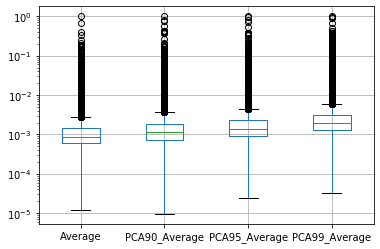

In [9]:
Q1_pca_bp = Q1_pca.loc[:,['Average','PCA90_Average','PCA95_Average','PCA99_Average']].boxplot(return_type='dict')
plt.yscale('log')

In [10]:
# Value of the upper whiskers @ 1.5*IQR+75th percentile for each column
# IQR = 75th percentile - 25th percentile
    # IQR = np.percentile(column data,75)-np.percentile(column data,25)
upper_whiskers = [item.get_ydata()[1] for item in Q1_pca_bp['whiskers'][1::2]]

In [11]:
upper_whiskers

[0.00274064501519969,
 0.003645773533233658,
 0.004375355487470943,
 0.00599121615323122]

In [12]:
Q1_pca_av_outs = Q1_pca_av[Q1_pca_av>upper_whiskers] # "Outliers" are extreme values, 
                                                     # data past the whiskers

In [11]:
Q1_pca_av_outs.describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average
count,14648.000000,13497.000000,14094.000000,15206.000000
mean,0.006358,0.008794,0.010214,0.013601
std,0.013967,0.020193,0.021422,0.023864
min,0.002741,0.003646,0.004375,0.005992
25%,0.003171,0.004273,0.005076,0.006939
50%,0.003905,0.005392,0.006318,0.008525
75%,0.006141,0.008583,0.009955,0.012990
max,1.000000,1.000000,1.000000,1.000000


In [12]:
# checking overlap
Q1_pca_av_outs.dropna().describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average
count,11559.000000,11559.000000,11559.000000,11559.000000
mean,0.007246,0.009586,0.011397,0.015710
std,0.015603,0.021719,0.023489,0.027025
min,0.002742,0.003647,0.004377,0.005993
25%,0.003528,0.004594,0.005596,0.007691
50%,0.004511,0.005929,0.007141,0.009856
75%,0.007188,0.009521,0.011310,0.015511
max,1.000000,1.000000,1.000000,1.000000


In [65]:
for col in Q1_pca_av_outs.columns:
    print(len(Q1_pca_av_outs.dropna())/len(Q1_pca_av_outs[col].dropna()))

0.7891179683233206
0.8564125361191376
0.8201362281822052
0.7601604629751414


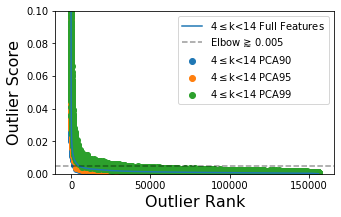

In [62]:
scores_sorted = Q1_pca_av.sort_values(by='Average',ascending=False)
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.plot(range(len(scores_sorted)),scores_sorted.Average,label="4$\leq$k<14 Full Features")
ref = 'PCA90_Average'
ax.scatter(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA90")
ref = 'PCA95_Average'
ax.scatter(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA95")
ref = 'PCA99_Average'
ax.scatter(range(len(scores_sorted)),scores_sorted.loc[:,ref],label="4$\leq$k<14 PCA99")

plt.axhline(.005,linestyle='--',color='black',alpha=.4,label='Elbow $\gtrapprox$ 0.005')
plt.ylabel('Outlier Score',fontsize=16)
plt.xlabel('Outlier Rank',fontsize=16)
plt.ylim(0,.1)
plt.xticks([0,50000,100000,150000])
#plt.yscale('log')
#plt.ylim(10E-6,10E0)
plt.legend()

In [18]:
scores_sorted[scores_sorted.Average>0.005].describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average
count,4943.000000,4943.000000,4943.000000,4943.000000
mean,0.011965,0.015805,0.018709,0.025781
std,0.023022,0.032164,0.034578,0.039091
min,0.005001,0.002256,0.003188,0.006332
25%,0.006089,0.007970,0.009593,0.013202
50%,0.007918,0.010398,0.012375,0.016998
75%,0.011865,0.015401,0.018616,0.025898
max,1.000000,1.000000,1.000000,1.000000


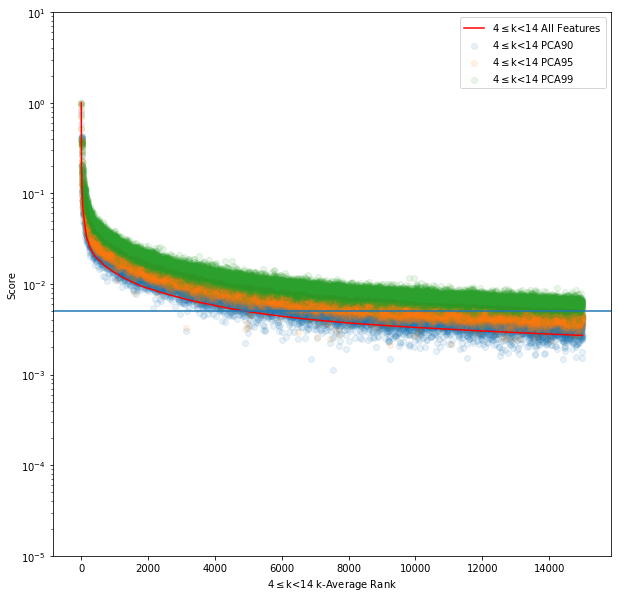

In [29]:
scores_sorted = Q1_pca_av.sort_values(by='Average',ascending=False).head(15000)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA90_Average,label="4$\leq$k<14 PCA90",alpha=.1)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA95_Average,label="4$\leq$k<14 PCA95",alpha=.1)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA99_Average,label="4$\leq$k<14 PCA99",alpha=.1)

ax.plot(range(len(scores_sorted)),scores_sorted.Average,c='red',label="4$\leq$k<14 All Features")
ax.axhline(.005)
plt.ylabel('Score')
plt.xlabel('4$\leq$k<14 k-Average Rank')
plt.yscale('log')
plt.ylim(10E-6,10E0)
plt.legend()

In [113]:
Q1_pca_av.loc[Q1_pca_av_outs.Average.dropna().index].min()

Average          0.002741
PCA90_Average    0.001121
PCA95_Average    0.002124
PCA99_Average    0.003516
dtype: float64

In [122]:
Q1_pca_av[Q1_pca_av>.01].dropna().describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average
count,1650.000000,1650.000000,1650.000000,1650.000000
mean,0.022144,0.029382,0.034495,0.047591
std,0.037802,0.053044,0.056545,0.061980
min,0.010001,0.010105,0.010941,0.015005
25%,0.011852,0.015288,0.018591,0.025790
50%,0.014730,0.018904,0.022816,0.032543
75%,0.020254,0.025964,0.030955,0.045466
max,1.000000,1.000000,1.000000,1.000000


## Should this all be log scaled?

In [21]:
Q1_pca_av_logged = Q1_pca_av.transform(np.log)

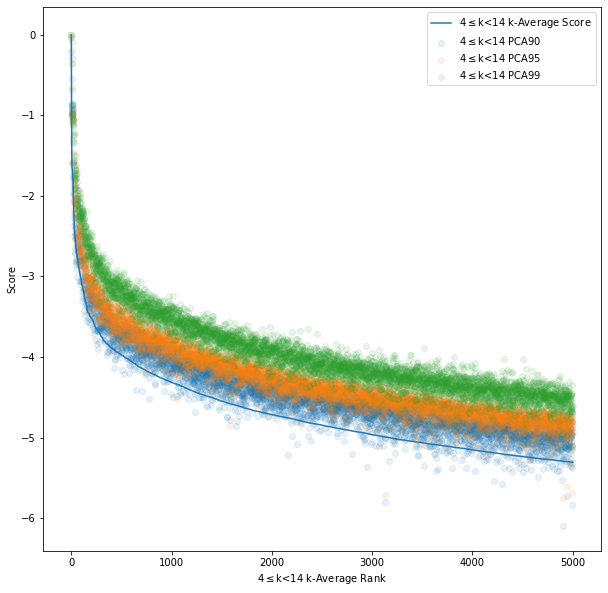

In [22]:
scores_sorted = Q1_pca_av_logged.sort_values(by='Average',ascending=False).head(5000)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA90_Average,label="4$\leq$k<14 PCA90",alpha=.1)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA95_Average,label="4$\leq$k<14 PCA95",alpha=.1)
ax.scatter(range(len(scores_sorted)),scores_sorted.PCA99_Average,label="4$\leq$k<14 PCA99",alpha=.1)

ax.plot(range(len(scores_sorted)),scores_sorted.Average,label="4$\leq$k<14 k-Average Score")

#plt.axhline(upper_whiskers[0])
plt.ylabel('Score')
plt.xlabel('4$\leq$k<14 k-Average Rank')
#plt.yscale('log')
#plt.ylim(10E-6,10E0)
plt.legend()

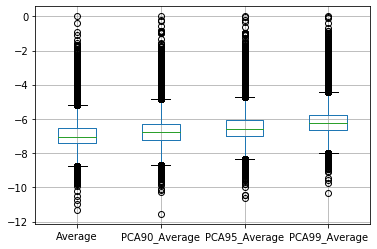

In [145]:
Q1_pca_av_logged.boxplot()

In [146]:
upper = Q1_pca_av_logged.describe().loc['75%']
lower = Q1_pca_av_logged.describe().loc['25%']
iqr = upper-lower
whisker = upper+1.5*iqr
whisker

Average         -5.200854
PCA90_Average   -4.827829
PCA95_Average   -4.712833
PCA99_Average   -4.418210
dtype: float64

In [148]:
Q1_pca_av_logged[Q1_pca_av_logged>whisker].dropna().describe()

,Average,PCA90_Average,PCA95_Average,PCA99_Average
count,3452.000000,3452.000000,3452.000000,3452.000000
mean,-4.481396,-4.211088,-4.035382,-3.707098
std,0.560466,0.556238,0.555327,0.573638
min,-5.198363,-4.827269,-4.707840,-4.417648
25%,-4.871502,-4.594765,-4.423561,-4.119243
50%,-4.632563,-4.363957,-4.171689,-3.844968
75%,-4.240696,-3.986538,-3.792311,-3.445893
max,0.000000,0.000000,0.000000,0.000000


In [160]:
top_average = Q1_pca_av.rank(ascending=False).sort_values(by='Average').head(10000).index

In [165]:
Q1_pca_av.rank(ascending=False).loc[top_average].describe().loc['max'].max()

79520.0

relative rank discrepency by top n

In [169]:
top_n = 10000
top_average = Q1_pca_av.rank(ascending=False).sort_values(by='Average').head(top_n).index
rank_diffs = Q1_pca_av.rank(ascending=False).loc[top_average]-Q1_pca_av.rank(ascending=False).loc[top_average].Average
pca90_diffs = Q1_pca_av.rank(ascending=False).loc[top_average].PCA90_Average-Q1_pca_av.rank(ascending=False).loc[top_average].Average
pca95_diffs = Q1_pca_av.rank(ascending=False).loc[top_average].PCA95_Average-Q1_pca_av.rank(ascending=False).loc[top_average].Average
pca99_diffs = Q1_pca_av.rank(ascending=False).loc[top_average].PCA99_Average-Q1_pca_av.rank(ascending=False).loc[top_average].Average
rank_diffs = pd.DataFrame(index=top_average,data={'PCA90_diff':pca90_diffs,
                                                       'PCA95_diff':pca95_diffs,
                                                       'PCA99_diff':pca99_diffs})
medians = rank_diffs.median()
rank_diffs.describe()


,PCA90_diff,PCA95_diff,PCA99_diff
count,10000.000000,10000.000000,10000.000000
mean,500.558000,240.214500,255.385600
std,2430.475593,1489.599636,1416.127057
min,-5472.000000,-3387.000000,-5435.000000
25%,-429.000000,-351.000000,-371.000000
50%,21.500000,8.000000,14.000000
75%,744.250000,469.250000,561.000000
max,71990.000000,34896.000000,20674.000000


In [9]:
top_ns = [100,200,300,400,500,750,1000,1250,1500,2000,2500,3000,4000,5000,7500,10000]
pca90_rankdiff_meds=[]
pca90_rankdiff_means=[]
pca90_rankdiff_stds=[]
for top_n in top_ns:
    top_average = Q1_pca_av.rank(ascending=False).sort_values(by='Average').head(top_n).index
    rank_diffs = Q1_pca_av.rank(ascending=False).loc[top_average]-Q1_pca_av.rank(ascending=False).loc[top_average].Average
    pca90_diffs = Q1_pca_av.rank(ascending=False).loc[top_average].PCA90_Average-Q1_pca_av.rank(ascending=False).loc[top_average].Average
    rank_diffs = pd.DataFrame(index=top_average,data={'PCA90_diff':pca90_diffs})
    pca90_rankdiff_meds.append(rank_diffs.PCA90_diff.median())
    pca90_rankdiff_means.append(rank_diffs.PCA90_diff.mean())
    pca90_rankdiff_stds.append(rank_diffs.PCA90_diff.std())

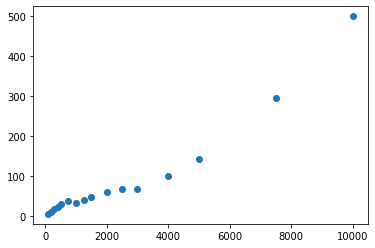

In [15]:

plt.scatter(top_ns,pca90_rankdiff_means)

In [286]:
from IPython.core.display import display, HTML

KIC = scores_sorted.index[0]
display(HTML("<a href=http://simbad.harvard.edu/simbad/sim-id?Ident=KIC{0}>KIC{0}</a>\n".format(KIC)))

In [8]:
from astroquery.simbad import Simbad

In [9]:
Simbad.reset_votable_fields()
Simbad.remove_votable_fields('main_id')
Simbad.add_votable_fields('typed_id')
Simbad.remove_votable_fields('coordinates')
Simbad.add_votable_fields('otype')
Simbad.add_votable_fields('coo')
Simbad.add_votable_fields('biblio')

In [47]:
from astropy.table import Table,vstack

In [106]:
nchunks = int(len(avscores)/1000)
chunks = [range(i*1000,i*1000+1000) for i in range(nchunks)]
lastchunk = range(nchunks*1000,nchunks*1000+len(avscores)%1000)
chunks.append(lastchunk)

In [98]:
for chunk in chunks[188:]:
    chunktable = Simbad.query_objects(['KIC{}'.format(i) for i in avscores.index[chunk]])
    chunktable.remove_columns(['COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE'])
    result_table = vstack([result_table,chunktable])

/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 17 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : KIC 11768293 
  (error.line, error.msg))
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 31 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : KIC 11768606 
  (error.line, error.msg))
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 50 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : KIC 11768885 
  (error.line, error.msg))
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The 

IndexError: too many indices for array

In [104]:
chunktable = Simbad.query_objects(['KIC{}'.format(i) for i in avscores.index[201000:]])
chunktable.remove_columns(['COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE'])
result_table = vstack([result_table,chunktable])

/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'KIC100003263' this identifier has an incorrect format for catalog: 	KIC : Kepler Input Catalog  
  (error.line, error.msg))
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 5 raised an error (recorded in the `errors` attribute of the result table): 'KIC100003265' this identifier has an incorrect format for catalog: 	KIC : Kepler Input Catalog  
  (error.line, error.msg))
/opt/anaconda3/envs/KeplerFull37/lib/python3.7/site-packages/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 7 raised an error (recorded in the `errors` attribute of the result table): 'KIC100003267' this identifier has an incorrect format for catalog: 	KIC : Kepler Input Catalog  
  (error.line

In [105]:
result_table

TYPED_ID,OTYPE,RA,DEC,BIBLIO
,,"""h:m:s""","""d:m:s""",
object,object,str13,str13,object
KIC757076,Star,19 24 09.2898,+36 35 53.121,2017ApJS..229...30M
KIC757099,Cepheid,19 24 10.3300,+36 35 37.602,2019MNRAS.484..834G|2016ApJ...829...23D|2014ApJS..211...24M|2011A&A...529A..89D
KIC757137,Eruptive*,19 24 13.4198,+36 33 35.724,2018ApJS..236...42Y|2016ApJ...829...23D
KIC 757280,,,,
KIC757450,RotV*,19 24 33.0185,+36 34 38.477,2019AJ....158...59S|2019MNRAS.482.1379H|2019MNRAS.484..834G|2018ApJ...855..115B|2018ApJ...856..155G|2018MNRAS.477..175O|2017A&A...602A.107B|2017AJ....153...66Z|2017AJ....153...71F|2017AJ....154...60W|2017AJ....154..107P|2017AJ....154..108J|2017MNRAS.465.2634A|2016ApJ...822...86M|2016ApJ...825...98H|2016ApJS..224...19M|2016ApJS..225....9H|2015A&A...575A..85B|2015ApJ...798...66D|2015ApJ...801....3M|2015ApJ...806...97K|2015ApJ...807...78F|2015ApJ...807..170H|2015ApJ...809....8B|2015ApJ...814..130M|2015ApJS..217...16R|2014AJ....147..119C|2014ApJS..210...19B|2013A&A...554A.114H|2013A&A...556A.150S|2013A&A...560A...4R|2013ApJ...775L..11M|2013ApJS..208...16M|2013MNRAS.436.1883W|2012ApJ...752...53L|2012ApJ...752...72D|2012ApJ...756..185F|2012ApJ...756..186S|2012ApJS..199...24T|2011A&A...529A..89D|2011ApJ...728..117B|2011ApJ...736...19B|2011ApJ...738..170M|2011ApJS..197....2F|2011ApJS..197...12D
KIC891901,Star,19 23 49.2382,+36 41 21.277,2015ApJ...809....8B
KIC891916,RotV*,19 23 49.9687,+36 41 11.833,2017A&A...603A..52R|2015A&A...583A..65R|2015ApJ...809....8B|2014ApJS..211...24M|2013A&A...557L..10N|2013A&A...560A...4R
KIC892010,Star,19 23 55.4473,+36 40 01.140,2018ApJS..236...42Y


In [112]:
simbad_summary_df = result_table.to_pandas().set_index(avscores.index).drop(columns='TYPED_ID')

In [151]:
simbad_summary_df['OTYPE']=simbad_summary_df.loc[:,'OTYPE'].apply(lambda x:x.decode())
simbad_summary_df['BIBLIO']=simbad_summary_df.loc[:,'BIBLIO'].apply(lambda x:x.decode())

In [152]:
simbad_summary_df

,OTYPE,RA,DEC,BIBLIO
KIC,,,,
757076,Star,19 24 09.2898,+36 35 53.121,2017ApJS..229...30M
757099,Cepheid,19 24 10.3300,+36 35 37.602,2019MNRAS.484..834G|2016ApJ...829...23D|2014Ap...
757137,Eruptive*,19 24 13.4198,+36 33 35.724,2018ApJS..236...42Y|2016ApJ...829...23D
757280,,,,
757450,RotV*,19 24 33.0185,+36 34 38.477,2019AJ....158...59S|2019MNRAS.482.1379H|2019MN...
...,...,...,...,...
100004295,,,,
100004297,,,,
100004298,,,,


In [154]:
full_summary_df = pd.concat([summary_df,simbad_summary_df],axis=1)

In [156]:
full_summary_df.head()

,median_rank,most_outlying_rank,most_outlying_quarter,OTYPE,RA,DEC,BIBLIO
KIC,,,,,,,
757076,38099.0,8427.0,Q14,Star,19 24 09.2898,+36 35 53.121,2017ApJS..229...30M
757099,2530.0,1563.0,Q2,Cepheid,19 24 10.3300,+36 35 37.602,2019MNRAS.484..834G|2016ApJ...829...23D|2014Ap...
757137,36285.0,13696.0,Q11,Eruptive*,19 24 13.4198,+36 33 35.724,2018ApJS..236...42Y|2016ApJ...829...23D
757280,39413.0,8991.0,Q10,,,,
757450,4610.0,2650.0,Q7,RotV*,19 24 33.0185,+36 34 38.477,2019AJ....158...59S|2019MNRAS.482.1379H|2019MN...


In [155]:
full_summary_df.to_csv('KIC_Summary.csv')

In [12]:
with open('scores/Average','rb') as f:
    avscores = pickle.load(f).set_index('KIC')


In [18]:
int(result_table['TYPED_ID'][0][3:])

8462852

In [13]:
summary_df = pd.DataFrame(index=avscores.index)

In [14]:
summary_df['median_rank']=avscores.rank(ascending=False).median(axis=1)

In [15]:
summary_df['most_outlying_rank']=avscores.rank(ascending=False).min(axis=1)

In [16]:
summary_df['most_outlying_quarter']=min_q

In [20]:
summary_df.sort_values(by='median_rank').head(20)

,median_rank,most_outlying_rank,most_outlying_quarter
KIC,,,
100003607,1.0,1.0,Q11
8451871,1.0,1.0,Q6
10057002,1.0,1.0,Q14
100004181,3.0,3.0,Q16
11506807,4.0,4.0,Q2
10053146,4.0,2.0,Q15
9594451,4.0,1.0,Q4
8415928,5.0,1.0,Q13
7446357,5.5,1.0,Q2


In [46]:
from numba import njit

In [ ]:
@njit
def minq(avscores,kic):
    avscores.loc[kic][avscores.rank(ascending=False).loc[kic]==avscores.rank(ascending=False).min(axis=1).loc[kic]].index[0]

In [65]:

min_q = []
for kic in avscores.head(100).index:
    min_q.append(avscores.loc[kic][avscores.rank(ascending=False).loc[kic]==avscores.rank(ascending=False).min(axis=1).loc[kic]].index[0])

In [67]:
min_q1=min_q

In [1]:
from multiprocessing import Pool,cpu_count
import pickle
import pandas as pd

In [2]:
with open('scores/Average','rb') as f:
    avscores = pickle.load(f).set_index('KIC')

In [3]:
def minq(kic):
    minloc = av_scores.rank(ascending=False).loc[kic]==av_scores.rank(ascending=False).min(axis=1).loc[kic]
    min_q = av_scores.loc[kic,minloc].index[0]
    return min_q
global av_scores #Pool.map can only take one variable... so I have to pass avscores as a global
av_scores=avscores

In [6]:
useCpus = cpu_count()
p = Pool(useCpus)
min_q = p.map(minq,av_scores.index)
p.close()
p.join()

True

In [53]:
from datetime import datetime

In [ ]:
for i in summary_df.index:
    minquarter = avscores.loc

### quick and dirty file lookup mechanism w/ the files csv


In [469]:
def file_lookup(KIC=[8462852],quarter="Q8"):
    with open('data/Kepler_fits_files.csv','r') as f:
        file_df = pd.read_csv(f).set_index('KIC')
    return file_df.loc[KIC,quarter]

In [475]:
filenames = file_lookup([8462852],"Q8")
[i[:13] for i in filenames]

['kplr008462852']

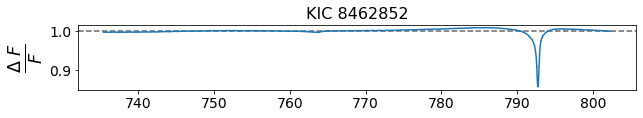

In [478]:
from astroquery.mast import Observations # how to remotely access Kepler data from Mast

n=1
filenames = list(file_lookup([8462852],"Q8"))
obj_ids = [i[:13] for i in filenames]

keplerObs = Observations.query_criteria(target_name=obj_ids, obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs)
yourProd = Observations.filter_products(keplerProds, extension=filenames)
manifest = Observations.download_products(yourProd)

manifest = manifest.to_pandas(index='Local Path')
fig = plt.figure(figsize=(10,1.2*n))

for i,f in enumerate(filenames): # forcing the order to match most to least outlying
    f_sampler = qt.make_sampler([f]) # to find the right file from manifest
    filename = f_sampler(manifest).index[0] # full local filepath
    t,nf,err = qt.read_kepler_curve(filename)
    ax = fig.add_subplot(n,1,i+1)
    ax.errorbar(t,nf,err)
    ax.set_title('KIC {}'.format(int(obj_ids[i][4:])),fontsize=16)
    ax.axhline(1,c='black',linestyle='--',alpha=.6)
    ax.tick_params(labelsize=14)
    if i!=len(filenames)-1:
        ax.set_xticklabels([])
    ax.set_ylabel(r"$\frac{\Delta~F}{F}$",fontsize=25)

In [485]:
file_df.head().iloc[:,:3].to_csv('llc_files')